<a href="https://colab.research.google.com/github/vinayshanbhag/math/blob/master/ProjectionProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Skew correction in scanned documents using projection profile

#### Introduction

Documents scanned using handheld devices are subject to some skew do to human errors. Projection profile is simple technique that works for scanned text documents. It relies on the fact that text documents are mostly composed of several lines of text. 

Given a scanned image like this -


In [0]:
import cv2
import numpy as np
import imutils
from PIL import Image
from scipy.ndimage import interpolation as inter
import matplotlib.pyplot as plt

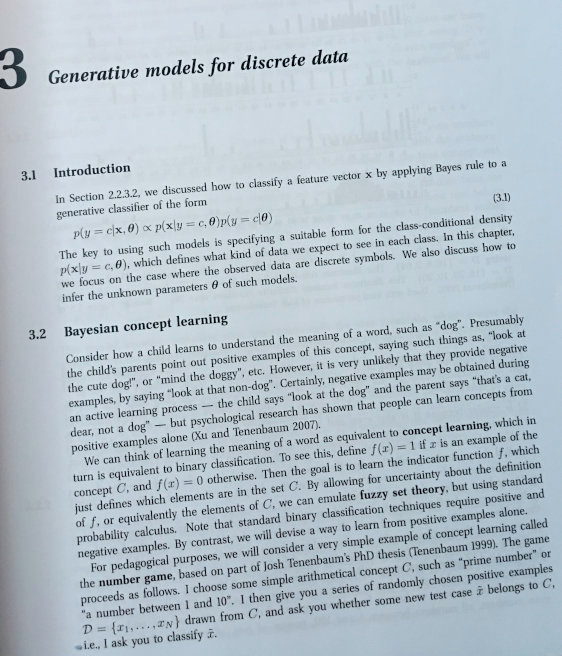

In [10]:
url = "https://github.com/vinayshanbhag/math/blob/master/File_000.jpeg?raw=true"
img = imutils.url_to_image(url)
Image.fromarray(img)

Convert to grayscale

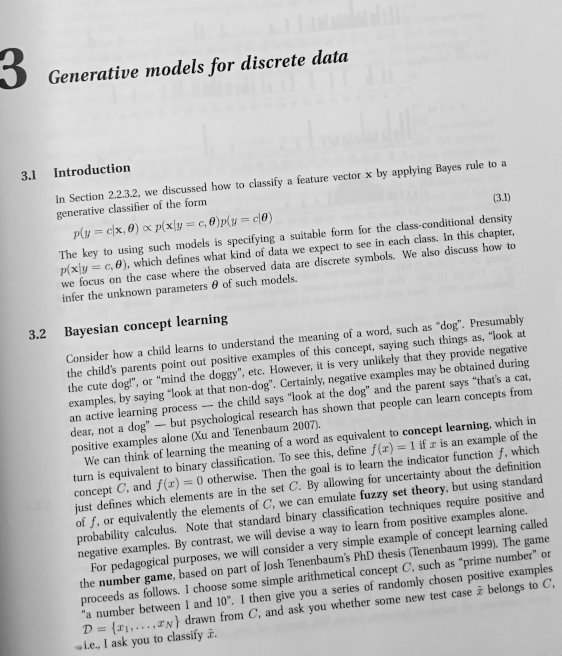

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Image.fromarray(gray)

Convert to binary

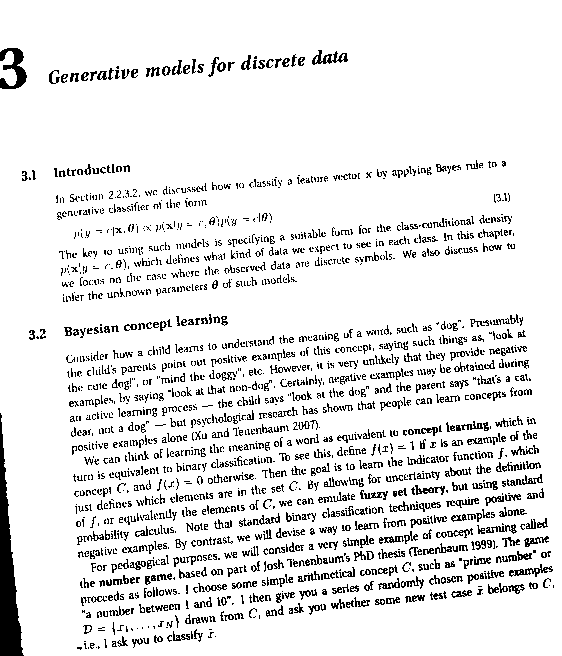

In [12]:
binary = 255-cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#binary = Image.fromarray(binary).resize((binary.shape[0]//2, binary.shape[1]//2), Image.ANTIALIAS)
Image.fromarray(binary)

#### Skew Detection

Summing all pixel values in each row gives us the horizontal projection for this image. 

$hproj = \sum_{row=1}^n image[i,:] $

The document is likely to be correctly aligned when the variation in the horizontal projection is the maximum. i.e. the values in the horizontal profile vary between - high values for the whitespace between lines and low values for the text. We can quantify this variation by taking a derivate of the horizontal profile values.

$gradient(\theta) = \sum |f'(hproj)|$

Since we do not know what the exact skew angle is, the image is rotated through a range of angles and the horizontal profile gradient is computed at each angle.
The actual skew angle can be found by looking at the angle that corresponds to the maximum gradient from all above trials.

$skew = \max(gradient(\theta))$

If the input image is very large, it can be scaled to a much smaller size. As this technique does not require high resolution image, we can speed up this process by using a tiny image for skew angle detection.

In [0]:
max_skew = 30
step = 1
skew_range = np.arange(-max_skew, max_skew+step,step)
gradient_scores = np.array([])
for angle in skew_range:
  values = inter.rotate(binary, angle, reshape=False, order=0)
  horizontal_projection = np.sum(values, axis=1).astype(float)
  score = np.sum(np.abs(np.gradient(horizontal_projection)))
  gradient_scores = np.append(gradient_scores, score)

skew_angle = skew_range[np.argmax(gradient_scores)]  

The derivative of the horizontal profile is plotted here for each angle of rotation. The peak here corresponds to the actual skew angle in the image.

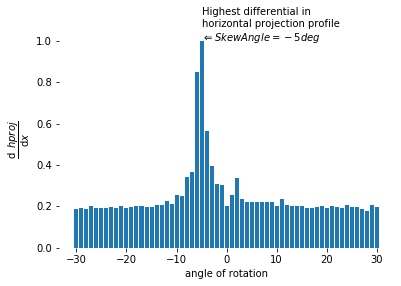

In [14]:
std_scores = gradient_scores/np.max(gradient_scores)
plt.bar(skew_range, std_scores);
plt.text(skew_angle,np.max(std_scores),f"Highest differential in \nhorizontal projection profile\n$\Leftarrow Skew Angle = {skew_angle}deg$");
plt.xlabel(r"angle of rotation")
plt.ylabel(r"$\dfrac{\mathrm{d}\hspace{.5}{hproj}}{\mathrm{d}x}$")
plt.box(None)

#### Skew Correction

Construct an affine rotation matrix with the skew angle and apply to the original image. 

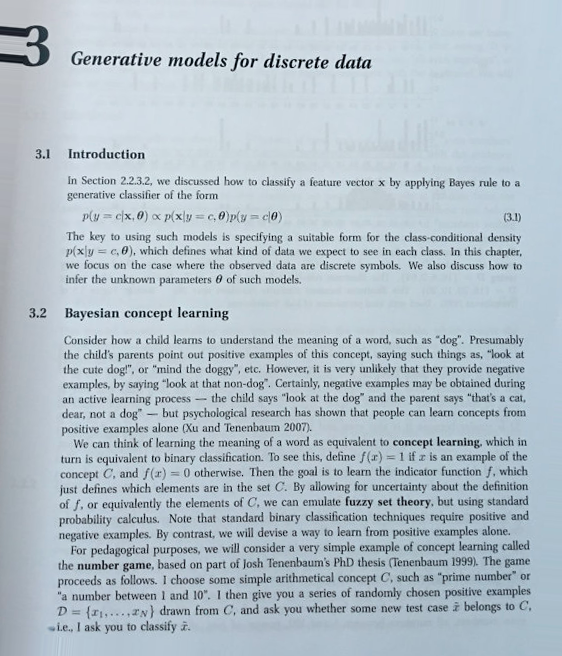

In [15]:
# Rotate original image by skew angle found above
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
R = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
corrected = cv2.warpAffine(img, 
                         R, 
                         (w, h), 
                         flags=cv2.INTER_CUBIC, 
                         borderMode=cv2.BORDER_REPLICATE # replicate pixels at the edge to fill gaps after rotation
                        )
Image.fromarray(corrected)

#### Applications

* As a post processing step in document scanning applications.
* As a pre-processing step for machine learning/ OCR applications.
* To identify and clip blocks of text from a large document. Each segment may then be processed separately per specific use case. e.g. in the sample image, we can use a combination of horizontal and vertical profiles to discern titles from paragraphs.

#### Limitations

This method of skew detection is based on the assumption that documents are composed of horizontal lines of text. Highly stylized text or text written vertically does not work very well. It does not work well with documents that have a very large skew angle or are oriented upside down.

